# TensorFlow model serving with Konduit Serving

This notebook illustrates a simple client-server interaction to perform inference on a TensorFlow model using the Python SDK for Konduit Serving.

This tutorial is split into three parts: 

1. Freezing models 
2. Configuration 
2. Running the server

In [1]:
from konduit import ParallelInferenceConfig, ServingConfig, TensorFlowConfig, ModelConfigType
from konduit import TensorDataTypesConfig, ModelPipelineStep, InferenceConfiguration
from konduit.server import Server
from konduit.client import Client

import tensorflow as tf
from tensorflow import keras
from keras.layers import Flatten, Dense, Dropout, Lambda
from keras.models import Sequential
from keras.datasets import mnist

from PIL import Image
import numpy as np
import time
import imageio
import os
import matplotlib.pyplot as plt 
import pandas as pd 

# newer versions of TensorFlow 
# from tensorflow.compat.v1 import graph_util
# comment out the above and uncomment the following for older versions of TensorFlow 
from tensorflow import graph_util

Using TensorFlow backend.


In [2]:
tensorflow_version = tf.__version__
print(tensorflow_version)

1.15.0


# Creating frozen models (Tensorflow 1.x)

In TensorFlow 1.x, "frozen" models can be exported in the TensorFlow Graph format. For deployment, we only need information on the graph and checkpoint variables. Freezing a model allows you to discard information that is not required for deploying your model. 

<div class="alert alert-warning">
    ⚠ TensorFlow 2.0 introduces the <a href="https://www.tensorflow.org/guide/saved_model">SavedModel format</a> as the universal format for saving models. Even though the deployable protobuff (PB) files have the same file extension as frozen TensorFlow Graph files, SavedModel protobuff files are not currently supported in Konduit Serving. A workaround for TensorFlow 2.0 is to adapt the code from this tutorial for your use case to create TensorFlow Graph protobuffs. 
</div>

The following code is adapted from `tf-import-examples` in the [`deeplearning4j-examples`](https://github.com/eclipse/deeplearning4j-examples/) repository.

In the following code, we build a model using TensorFlow's Keras API and save it as a TensorFlow Graph. 

In [3]:
# Load data
train_data, test_data = mnist.load_data()
x_train, y_train = train_data
x_test, y_test = test_data

# Normalize
x_train = x_train / 255.0
x_test  = x_test / 255.0

weights = None

def get_model(training=False):
    """Build a model in Keras 
    """
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))
    model.add(Dense(512, activation='relu'))
    if training:
        model.add(Dropout(0.5))
    else:
        model.add(Lambda(lambda x: x + 0.))
    model.add(Dense(10, activation='softmax'))
    model.compile(
        optimizer='sgd', 
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy']
    )
    return model

def train():
    with tf.Session() as sess:
        keras.backend.set_session(sess)
        model = get_model(True)
        model.fit(x_train, y_train, epochs=5)
        global weights
        weights = model.get_weights()

def save():
    # save model to a protobuff
    with tf.Session() as sess:
        keras.backend.set_session(sess)
        model = get_model(False)
        model.set_weights(weights)
        model.evaluate(x_test, y_test)
        sess.run(tf.global_variables_initializer())
        output_node_name = model.output.name.split(':')[0]
        output_graph_def = graph_util.convert_variables_to_constants(
            sess, 
            sess.graph.as_graph_def(), 
            [output_node_name]
        )
        with tf.gfile.GFile(
            name=f"../data/mnist/mnist_{tensorflow_version}.pb", 
            mode="wb"
        ) as f:
            f.write(output_graph_def.SerializeToString())

train()
save()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Epoch 1/5
60000/60000 [==============================] - 7s 117us/step - loss: 0.6961 - accuracy: 0.8050
Epoch 2/5
60000/60000 [==============================] - 4s 71us/step - loss: 0.3807 - accuracy: 0.8918
Epoch 3/5
60000/60000 [==============================] - 4s 68us/step - loss: 0.3167 - accuracy: 0.9098
Epoch 4/5
60000/60000 [==============================] - 4s 71us/step - loss: 0.2793 - accuracy: 0.9203
Epoch 5/5
10000/10000 [==============================] - 1s 110us/step
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 4 variables.
INFO:tensorflow:Converted 4 variables to const ops.


## Configuration

Konduit Serving works by defining a series of "pipeline steps". These include operations such as 
1. Pre- or post-processing steps
2. One or more machine learning models
3. Transforming the output in a way that can be understood by humans

If deploying your model does not require pre- nor post-processing, only one pipeline step - a machine learning model - is required. This configuration is defined using a single `ModelPipelineStep`. 

Before running this notebook, run the `build_jar.py` script and copy the JAR (`konduit.jar`) to this folder. Refer to the [Python SDK README](https://github.com/KonduitAI/konduit-serving/blob/master/python/README.md) for details. 

### Configuring `ModelPipelineStep` 

Define the TensorFlow configuration as a `TensorFlowConfig` object. 

- `tensor_data_types_config`: The TensorFlowConfig object requires a dictionary `input_data_types`. Its keys should represent column names, and the values should represent data types as strings, e.g. `"INT32"`. See [here](https://github.com/KonduitAI/konduit-serving/blob/master/konduit-serving-api/src/main/java/ai/konduit/serving/model/TensorDataType.java) for a list of supported data types. 
- `model_config_type`: This argument requires a `ModelConfigType` object. Specify `model_type` as `TENSORFLOW`, and `model_loading_path` to point to the location of TensorFlow weights saved in the PB file format.


In [4]:
input_data_types = {'flatten_2_input': 'FLOAT'}

tensorflow_config = TensorFlowConfig(
    tensor_data_types_config = TensorDataTypesConfig(
        input_data_types=input_data_types
        ),
    model_config_type = ModelConfigType(
        model_type='TENSORFLOW',
        model_loading_path=os.path.abspath(
            f'../data/mnist/mnist_{tensorflow_version}.pb'
        )
    )
)

Now that we have a `TensorFlowConfig` defined, we can define a `ModelPipelineStep`. The following parameters are specified: 
- `model_config`: pass the TensorFlowConfig object here 
- `parallel_inference_config`: specify the number of workers to run in parallel. Here, we specify `workers = 1`.
- `input_names`:  names for the input data  
- `output_names`: names for the output data

In [5]:
input_names = list(input_data_types.keys())
output_names = ["dense_4/Softmax"]

tf_pipeline_step = ModelPipelineStep(
    model_config=tensorflow_config,
    parallel_inference_config=ParallelInferenceConfig(workers=1),
    input_names=input_names,
    output_names=output_names
)

### Configuring the server

Specify the following:
- `http_port`: select a random port.
- `input_data_type`, `output_data_type`: Specify input and output data types as strings. 

<div class="alert alert-info">
ℹ Accepted input and output data types are as follows: 
    <ul>
        <li> Input: JSON, ARROW, IMAGE, ND4J (not yet implemented) and NUMPY. </li>
        <li> Output: NUMPY, JSON, ND4J (not yet implemented) and ARROW.</li>
    </ul>
</div>

In [6]:
port = np.random.randint(1000, 65535)
serving_config = ServingConfig(
    http_port=port,
    input_data_type='NUMPY',
    output_data_type='NUMPY'
)

The `ServingConfig` has to be passed to `InferenceConfiguration` in addition to the pipeline steps as a Python list. In this case, there is a single pipeline step: `tf_pipeline_step`. 

In [7]:
server = Server(
    config=InferenceConfiguration(
        serving_config=serving_config,
        pipeline_steps=[tf_pipeline_step]
    )
)

By default, `Server()` looks for the Konduit Serving JAR `konduit.jar` in the directory the script is run in. To change this default, use the `jar_path` argument.

The configuration is stored as a dictionary. Note that the configuration can be converted to a dictionary using the `as_dict()` method: 

In [8]:
server.config.as_dict()

{'@type': 'InferenceConfiguration',
 'pipelineSteps': [{'@type': 'ModelPipelineStep',
   'inputNames': ['flatten_2_input'],
   'outputNames': ['dense_4/Softmax'],
   'modelConfig': {'@type': 'TensorFlowConfig',
    'tensorDataTypesConfig': {'@type': 'TensorDataTypesConfig',
     'inputDataTypes': {'flatten_2_input': 'FLOAT'}},
    'modelConfigType': {'@type': 'ModelConfigType',
     'modelType': 'TENSORFLOW',
     'modelLoadingPath': 'C:\\Users\\Skymind AI Berhad\\Documents\\konduit-serving-examples\\data\\mnist\\mnist_1.15.0.pb'}},
   'parallelInferenceConfig': {'@type': 'ParallelInferenceConfig',
    'workers': 1}}],
 'servingConfig': {'@type': 'ServingConfig',
  'httpPort': 21578,
  'inputDataType': 'NUMPY',
  'outputDataType': 'NUMPY'}}

### Configuring the client 

To configure the client, create a Client object with the following arguments: 
- `input_names`: names of the input data
- `output_names`: names of the output data
- `input_type`: data type passed to the server for inference
- `endpoint_output_type`: data type returned by the server endpoint 
- `return_output_type`: data type to be returned to the client. Note that this argument can be used to convert the output returned from the server to the client into a different format, e.g. NUMPY to JSON.


<div class="alert alert-warning">
    ⚠ Future versions of the Python SDK may remove the <code>input_names</code> and <code>output_names</code> arguments in <code>Client()</code>, since these are already specified in <code>ModelPipelineStep()</code>. 
</div>

In [9]:
client = Client(
    input_names=input_names,
    output_names=output_names,
    input_type='NUMPY',
    endpoint_output_type='NUMPY',
    return_output_type="NUMPY",
    url='http://localhost:' + str(port)
)

## Running the server 

Load some sample data from NumPy files. Note that these are NumPy arrays, each with shape (4, 128): 

In [10]:
read_image = lambda x: np.array(imageio.imread(f"../data/mnist/img_{x}.jpg")).astype(np.int)
imgs = list(map(read_image, np.arange(1, 4)))

Note the following: 
- `imageio.imread` produces a NumPy array subclass. This should be coerced into a regular `np.ndarray` using `np.array()` to be accepted by Konduit Serving. 
- the data type of NumPy arrays produced by `imageio.imread` is `np.uint8`. This is not supported by Konduit Serving, and you should cast the array into a supported type using the `.astype()` method. 

Start the server and wait 30 seconds for the server to start before the client requests the server for a prediction using the `data_input`. 

Wrote config.json to path C:\Users\Skymind AI Berhad\Documents\konduit-serving-examples\python\config.json
Running with args
java -cp konduit.jar ai.konduit.serving.configprovider.KonduitServingMain --configPath C:\Users\Skymind AI Berhad\Documents\konduit-serving-examples\python\config.json --verticleClassName ai.konduit.serving.verticles.inference.InferenceVerticle


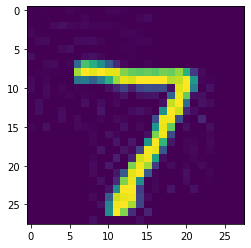

{0: 0.0, 1: 0.0, 2: 0.0, 3: 1.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0}


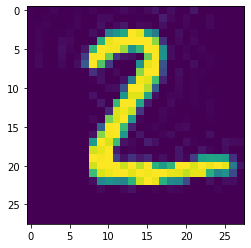

{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 1.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0}


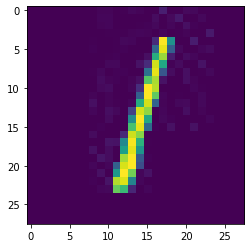

{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 1.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0}


In [11]:
server.start()
time.sleep(30)

for img in imgs: 
    plt.imshow(img)
    predicted = client.predict(
        data_input={'flatten_2_input': img}
    )
    plt.show()
    print(dict(zip(np.arange(10), predicted[0].round(3))))

## Batch prediction

To predict in batches, the `data_input` dictionary has to be specified differently for client images in NDARRAY format. To input a batch of observations, use the index operator in the keys for each image in the batch. An example is as follows: 

In [12]:
predicted = client.predict(
    data_input={'flatten_2_input[0]': imgs[0], 
                'flatten_2_input[1]': imgs[1], 
                'flatten_2_input[2]': imgs[2]}
)

server.stop()

Wrote config.json to path C:\Users\Skymind AI Berhad\Documents\konduit-serving-examples\python\config.json
Running with args
java -cp konduit.jar ai.konduit.serving.configprovider.KonduitServingMain --configPath C:\Users\Skymind AI Berhad\Documents\konduit-serving-examples\python\config.json --verticleClassName ai.konduit.serving.verticles.inference.InferenceVerticle


In [13]:
pd.DataFrame(predicted).round(3)

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
